Определение языка (language detection)
--------------------

* **Множество случаев** — тексты на разных языках
* **Множество классов** — языки

In [257]:
import json

In [258]:
wiki_texts = json.loads(open('Zueva_wiki_texts.json', 'r', encoding='utf8').read())

In [259]:
for lang in wiki_texts:
    print(lang, len(wiki_texts[lang]))

de 90
tt 90
bg 90
fr 90
ba 90
uk 90
be 90
en 90
ru 90


In [260]:
from sklearn.model_selection import train_test_split

In [261]:
train_texts = defaultdict(lambda: 0)
test_texts = defaultdict(lambda: 0)

for lang in wiki_texts:
    train, test = train_test_split(wiki_texts[lang], test_size=0.30, random_state=42) 
    train_texts[lang] = train
    test_texts[lang] = test

In [262]:
for lang in train_texts:
    print(lang, len(train_texts[lang]))

ba 63
tt 63
bg 63
fr 63
de 63
uk 63
ru 63
en 63
be 63


In [263]:
for lang in test_texts:
    print(lang, len(test_texts[lang]))

ba 27
tt 27
bg 27
fr 27
de 27
uk 27
ru 27
en 27
be 27


In [264]:
from collections import Counter
from collections import defaultdict
from string import punctuation, digits
from sklearn.metrics import classification_report, confusion_matrix
punctuation = set(punctuation + '«»—–…“”\n\t№' + digits) - set('-')
table = str.maketrans({ch: None for ch in punctuation})

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

### Первый метод: частотные слова

In [266]:
def tokenize(text):
    return text.translate(table).split(' ')

In [267]:
freqs = defaultdict(Counter)
table = str.maketrans({ch: ' ' for ch in punctuation})

for lang in train_texts:
    for text in train_texts[lang]:
        tokenized = tokenize(text.lower())
        freqs[lang].update(tokenized)

freq_list = {}
for lang in freqs:
    topn = [word for word, freq in freqs[lang].most_common(300)]
    freq_list[lang] = set(topn)

In [268]:
def predict_language_freqlist(text, freqs):
    tokenized = set(tokenize(text.lower()))
    
    choices = defaultdict(lambda: 0)
    
    for lang in freqs:
        for word in tokenized:
            if word in freqs[lang]:
                choices[lang] += 1
    
    return max(choices, key=lambda x: choices[x])

In [269]:
true_labels = []
predicted_labels = []

for lang in test_texts:
    for text in test_texts[lang]:
        true_labels.append(lang)
        predicted_labels.append(predict_language_freqlist(text, freq_list))

In [270]:
print(classification_report(true_labels, predicted_labels))

             precision    recall  f1-score   support

         ba       1.00      1.00      1.00        27
         be       1.00      1.00      1.00        27
         bg       0.96      0.96      0.96        27
         de       0.96      1.00      0.98        27
         en       0.96      1.00      0.98        27
         fr       1.00      1.00      1.00        27
         ru       1.00      1.00      1.00        27
         tt       1.00      0.96      0.98        27
         uk       1.00      0.96      0.98        27

avg / total       0.99      0.99      0.99       243



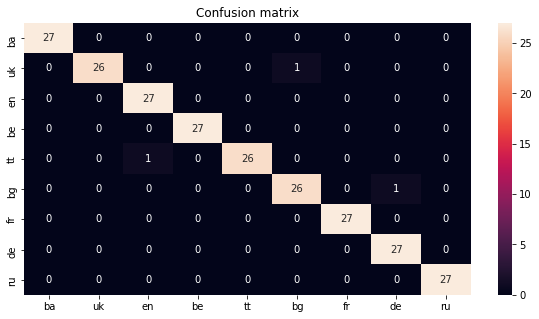

In [271]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(true_labels, predicted_labels, labels = labels), 
            annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

### Второй метод: частотные символьные n-граммы

In [272]:
from itertools import islice, tee

def make_ngrams(text):
    N = 3 # задаем длину n-граммы
    ngrams = zip(*(islice(seq, index, None) for index, seq in enumerate(tee(text, N))))
    ngrams = set(''.join(x) for x in ngrams)
    return ngrams

In [273]:
lang2char_ngrams_freqs = defaultdict(Counter)

for lang in train_texts:
    for text in train_texts[lang]:
        char_ngrams = make_ngrams(text.lower().translate(table))
        lang2char_ngrams_freqs[lang].update(char_ngrams)

lang2char_ngrams = {}
for lang in lang2char_ngrams_freqs:
    topn = [word for word, freq in lang2char_ngrams_freqs[lang].most_common(500)]
    lang2char_ngrams[lang] = set(topn)

In [274]:
def predict_language_ngrams(text, lang2char):
    text_ngrams = make_ngrams(text.lower().translate(table))
    
    lang2sim = {}
    
    for lang in lang2char:
        intersect = len((text_ngrams - punctuation) & lang2char[lang])
        lang2sim[lang] = intersect
    
    return max(lang2sim, key=lambda x: lang2sim[x])

In [275]:
true_labels = []
predicted_labels = []

for lang in test_texts:
    for text in test_texts[lang]:
        true_labels.append(lang)
        predicted_labels.append(predict_language_ngrams(text, lang2char_ngrams))

In [276]:
print(classification_report(true_labels, predicted_labels))

             precision    recall  f1-score   support

         ba       1.00      1.00      1.00        27
         be       1.00      1.00      1.00        27
         bg       1.00      1.00      1.00        27
         de       1.00      1.00      1.00        27
         en       0.96      1.00      0.98        27
         fr       1.00      1.00      1.00        27
         ru       1.00      1.00      1.00        27
         tt       1.00      0.96      0.98        27
         uk       1.00      1.00      1.00        27

avg / total       1.00      1.00      1.00       243



In [277]:
labels = list(set(true_labels))

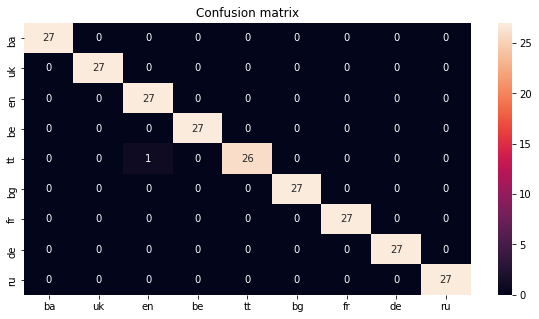

In [278]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(true_labels, predicted_labels, labels = labels), 
            annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

### Программа

In [279]:
def check_file(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        text = f.read()
        print('Опираясь на список частотных слов, можно сказать, что это текст на языке: {}.'.format(
                                                                                        predict_language_freqlist(
                                                                                                    text,
                                                                                                    freq_list
                                                                                        )))
        print('Опираясь на n-граммы, можно сказать, что это текст на языке: {}.'.format(
                                                                                        predict_language_ngrams(
                                                                                                    text,
                                                                                                    lang2char_ngrams
                                                                                        )))

In [280]:
check_file('HW3_Zueva_file')

Опираясь на список частотных слов, можно сказать, что это текст на языке: tt.
Опираясь на n-граммы, можно сказать, что это текст на языке: tt.
